## Estadística Aplicada

Sesión 14 - 17 octubre

Alexandra Guadalupe Valdez Mireles 

1910361

Gpo 44

In [1]:
## Librerías Básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
## Librerías Especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [4]:
## Definir tamaño de gráfica
plt.rcParams['figure.figsize'] = (10,6)

In [6]:
## Datos 
igae_deses = pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/igae_deses.csv')

* ARIMA(p, I, q) = Series sin componente estacional
* SARIMA = Series con componente estacional

In [7]:
igae_deses.head(3)

,meses,IGAE_DESES
0,1993/01,56.282290
1,1993/02,57.708594
2,1993/03,57.825254


In [ ]:
## Para utilizar herramientas de tiempo de statsmodels: 
## Necesitamos que esté en formato fecha
## Que sea el index
## Que haya una frecuencia asignada 

In [9]:
## Formato fecha
igae_deses['meses'] = pd.to_datetime(igae_deses['meses'], format='%Y/%m')

In [10]:
igae_deses.dtypes

meses         datetime64[ns]
IGAE_DESES           float64
dtype: object

In [11]:
## Que sea el index
igae_deses = igae_deses.set_index('meses')

In [12]:
igae_deses.head(1)

,IGAE_DESES
meses,
1993-01-01,56.28229


In [13]:
## Que haya una frecuencia asignada
igae_deses = igae_deses.asfreq('MS')

In [14]:
igae_deses.index

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
               '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
               '1993-09-01', '1993-10-01',
               ...
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='meses', length=367, freq='MS')

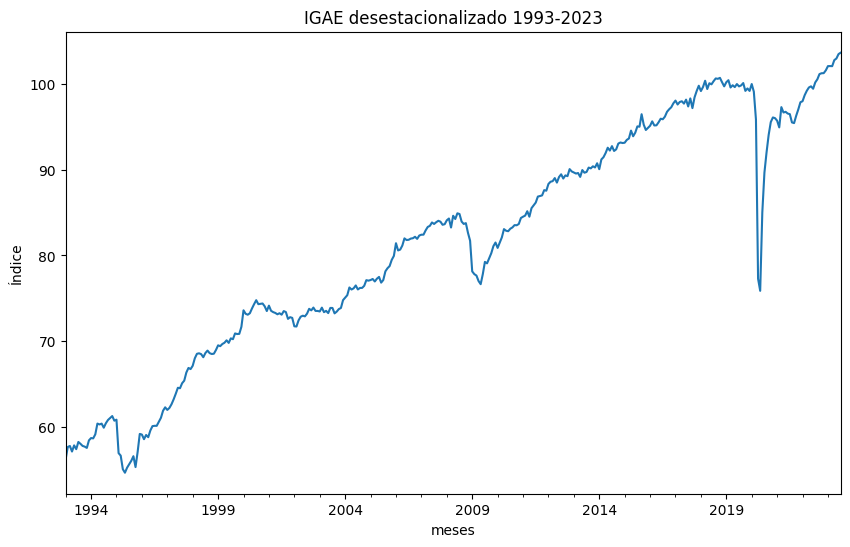

In [18]:
## Siempre primero graficar
igae_deses['IGAE_DESES'].plot()
plt.title('IGAE desestacionalizado 1993-2023')
plt.ylabel('Índice');

El igae se parece a una caminata aleatoria con deriva positiva y por tanto sospechamos que es un proceso no estacionario 

In [22]:
## Para verificar usamos la prueba Dickey-Fuller Aumentada
## Ho: No es proceso estacionario
## Ha: Proceso estacionario

dfa_test = adfuller(igae_deses['IGAE_DESES'])
pvalue1 = dfa_test[1]
pvalue1.round(2)

0.74

In [20]:
dfa_test

(-1.0481779348666833,
 0.7352896929912627,
 2,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 1147.2710040898037)

Con un pvalue de 0.74 NO rechazamos Ho, significa que el igae es una serie no estacionaria.

In [23]:
## Como la series es no estacionaria, para poder pronosticar debemos convertirla a estacionaria aplicado primeras diferencias

igae_deses['igae_diff'] = igae_deses['IGAE_DESES'].diff()

In [24]:
igae_deses

,IGAE_DESES,igae_diff
meses,,
1993-01-01,56.282290,NaN
1993-02-01,57.708594,1.426305
1993-03-01,57.825254,0.116660
1993-04-01,57.179522,-0.645732
1993-05-01,57.895451,0.715929
...,...,...
2023-03-01,102.032776,-0.011138
2023-04-01,102.735045,0.702268
2023-05-01,102.924688,0.189644


In [28]:
## Hacer nuevamente Prueba Dickey_Fuller aumentada a las 1ras diferencias del IGAE
## Eliminar missing values con dropna()

dfa_test1 = adfuller(igae_deses['igae_diff'].dropna())
pvalue2 = dfa_test1[1]
pvalue2.round(3)

0.0

Como el pvalue = 0.0 rechazamos Ho, significa que el igae_diff es un proceso estacionario 

* IGAE = Integrado de orden uno I(1)
* igae_diff = Integrado de orden cero I(0)

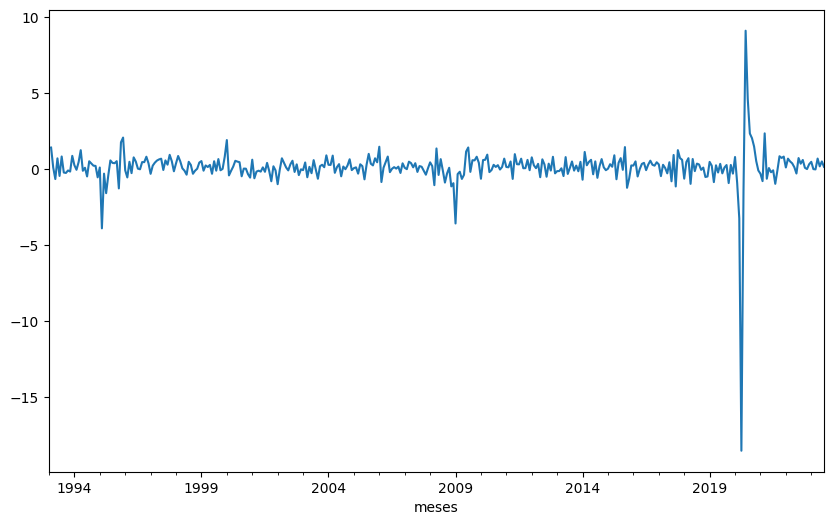

In [29]:
igae_deses['igae_diff'].plot();

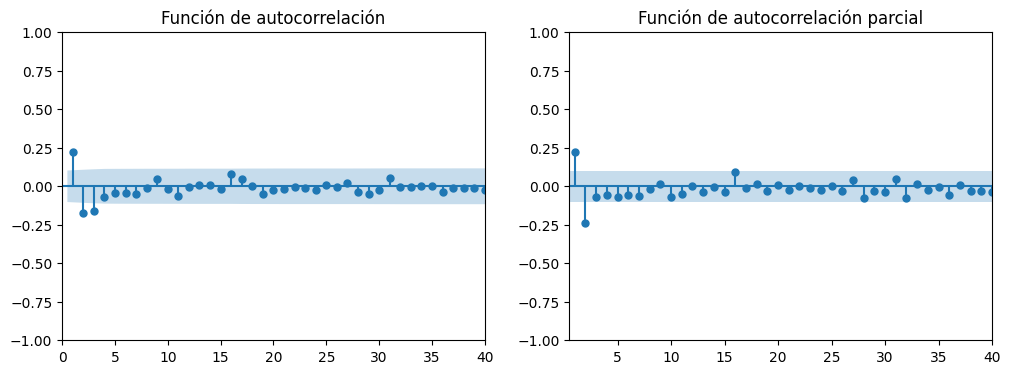

In [34]:
## igae_deses sabemos que es estacionario pero,
## ¿qué tipo de proceso estacionario es? 
## Para averiguarlo usaremos la función de autocorrelación y la función de autocorrelación parcial

ig, ax = plt.subplots(1, 2, figsize=(12,4))
## Subgráfica 1 (autocorrelación)
plot_acf(igae_deses['igae_diff'].dropna(), zero=False, lags=40, ax=ax[0], title='Función de autocorrelación')
ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,40)
## Subgráfica 2 (autocorrelación parcial)
plot_pacf(igae_deses['igae_diff'].dropna(), zero=False, lags=40, ax=ax[1], title='Función de autocorrelación parcial')
ax[1].set_ylim(-1,1)
ax[1].set_xlim(0.5,40)
plt.show()

ARIMA (p, I, q)

Sospechamos que igae_diff es un AR(1) = ARMA(1,0) = ARIMA(1,0,0)

In [35]:
## Las gráficas no son muy claras para saber qué proceso es, así que usaremos un método alternativo
## Vamos a estimar un ARIMA (1,0,0)
modelo_prueba = ARIMA(igae_deses['igae_diff'].dropna(), order=(1,0,0))
resultadop = modelo_prueba.fit() 
print(resultadop.summary())

                               SARIMAX Results                                
Dep. Variable:              igae_diff   No. Observations:                  366
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -602.265
Date:                Tue, 17 Oct 2023   AIC                           1210.530
Time:                        12:26:11   BIC                           1222.238
Sample:                    02-01-1993   HQIC                          1215.182
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1303      0.118      1.100      0.271      -0.102       0.363
ar.L1          0.2219      0.027      8.070      0.000       0.168       0.276
sigma2         1.5731      0.021     74.742      0.0

Este modelo nos dice que la ecuación de igae_diff es:
$$ Y_t = 0.2219 Y_{t-1} + \varepsilon_t $$

In [36]:
## Suponemos que es un AR(2) = ARIMA(2,0,0)
modelo_prueba2 = ARIMA(igae_deses['igae_diff'].dropna(), order=(2,0,0))
resultadop2 = modelo_prueba2.fit() 
print(resultadop2.summary())

                               SARIMAX Results                                
Dep. Variable:              igae_diff   No. Observations:                  366
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -591.689
Date:                Tue, 17 Oct 2023   AIC                           1191.379
Time:                        12:32:18   BIC                           1206.989
Sample:                    02-01-1993   HQIC                          1197.582
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1292      0.110      1.179      0.238      -0.085       0.344
ar.L1          0.2747      0.027     10.270      0.000       0.222       0.327
ar.L2         -0.2367      0.017    -14.275      0.0

Este modelo nos dice que la ecuación de igae_diff es:
$$ Y_t = 0.27 Y_{t-1} - 0.23 Y_{t-2} + \varepsilon_t $$

Si pvalue fuera menor al alpha habría que poner el valor de esa constante, si es mayor no se agrega a la ecuación.

In [39]:
## Vamos a estimar varios modelos y gardar el AIC BIC
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(igae_deses['igae_diff'].dropna(), order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar,ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])   

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 1, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 1, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 0
AR: 2, MA: 1
AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 0
AR: 3, MA: 1


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 2


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 3


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 2


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 3


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4
AR: 4, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 2
AR: 5, MA: 3


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 4


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 2


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 3


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 4


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\Users\FCFM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
ic.sort_values('AIC', ascending=True).head(1)

,,AIC,BIC
AR,MA,,
3,1,1183.372561,1206.788361


* igae_diff es un ARMA (3,1) = ARIMA (3,0,1)
* Igae es un ARIMA (3,1,1) -> I=1, POR INTEGRADO DE ORDEN 1